In [52]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
# nn architecture
class FCN(nn.Module):
    
    # Defines a fully connected NN in Pytorch
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        
        # activation function
        activation = nn.Tanh
        
        # input layer
        self.fcs = nn.Sequential(*[
                                    nn.Linear(N_INPUT, N_HIDDEN),
                                    activation()])
        
        # hidden layers
        self.fch = nn.Sequential(*[nn.Sequential(*[
                                    nn.Linear(N_HIDDEN, N_HIDDEN),
                                    activation()]) for i in range(N_LAYERS-1)])
        
        # output layer
        
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
        # forward propagation
    def forward(self, x):
            x = self.fcs(x)
            x = self.fch(x)
            x = self.fce(x)
            return x    

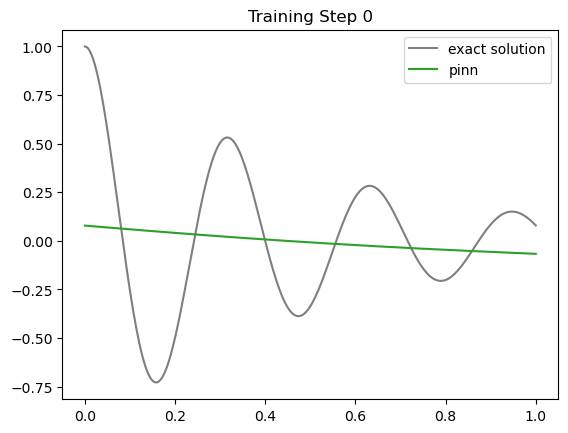

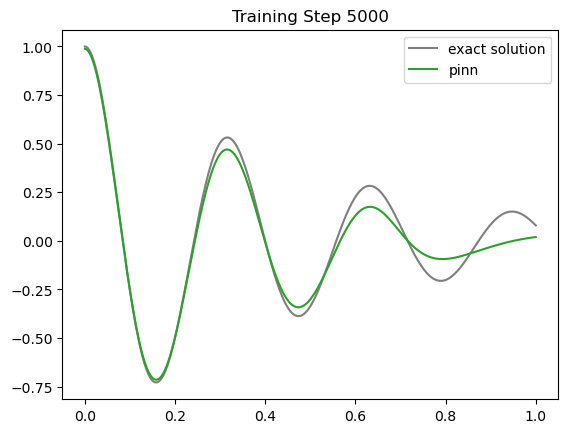

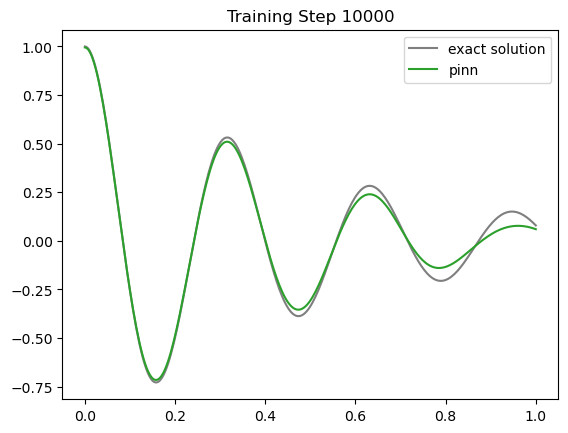

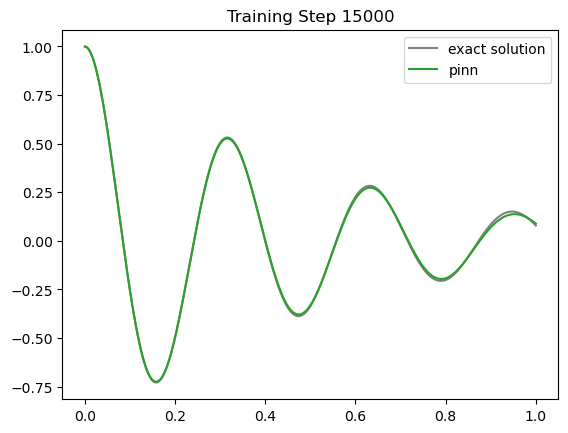

In [71]:
# HARMONIC OSCILLATOR PINN

# exact solution of harmonic equation
def exact_solution(d, w0, t):
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi + w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

# seed for nn
torch.manual_seed(123)

# define nn to train
pinn = FCN(1, 1, 32, 3)
#pinn = pinn.to(device)

# boundary points, t = 0
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)

# training points in time
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

# equation parameters
d, w0 = 2, 20
mu, k = 2*d, w0**2

t_test = torch.linspace(0, 1, 300).view(-1, 1)
u_exact = exact_solution(d, w0, t_test)

# define optimiser, learning rate
optimiser = torch.optim.Adam(pinn.parameters(), lr = 1e-3)

for i in range(15001):
    
    optimiser.zero_grad()
    
    # hyperparameters for loss function
    lambda1, lambda2 = 1e-1, 1e-4
    
    # boundary loss
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1)**2
    
    # find derivatives
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph = True)[0]
 
    loss2 = lambda1 * (torch.squeeze(dudt) - 0)**2
    
    # physics loss - diff equation
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph = True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph = True)[0]
    loss3 = lambda2 * torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    # backpropagate
    loss = loss1 + loss2 + loss3
    loss.backward()
    optimiser.step()
    
    if i % 5000 == 0:
    
        u = pinn(t_test).detach()
        plt.figure()
        plt.plot(t_test[:,0], u_exact[:,0], label = 'exact solution', color = 'tab:grey')
        plt.plot(t_test[:,0], u[:,0], label = 'pinn', color = 'tab:green')
        plt.title(f"Training Step {i}")
        plt.legend()
        plt.show()
        

In [68]:
# modelling coursework

# exact solution of modelling coursework
def TransientAnalyticSoln(x, t):
    
    trans = 0
    for k in range(1, 1001):
        trans += ((((-1)**k)/k) * np.exp(-k**2*np.pi**2*t)*np.sin(k*np.pi*x))
    c = x + (2/np.pi)*trans
    return c


# seed for nn
torch.manual_seed(123)

# define nn to train, two inputs for x and t
pinn = FCN(1, 1, 32, 3)

# boundary points, t = 0
t_boundary = np.zeros([32, 1])
x_boundary1 = np.zeros([32, 1])
x_boundary2 = np.ones([32, 1])

x_bc = Variable(torch.from_numpy(x_boundary1).float(), requires_grad=False)
t_bc = Variable(torch.from_numpy(t_boundary).float(), requires_grad=False)

# x boundaries
x_boundary0 = torch.tensor(0.).view(-1, 1).requires_grad_(True)
x_boundary1 = torch.tensor(1.).view(-1, 1).requires_grad_(True)




# training points in time
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)
x_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)



# equation parameters
D = 1

# exact solution
t_test = torch.linspace(0, 1, 300).view(-1, 1)
x_test = torch.linspace(0, 1, 300).view(-1, 1)
u_exact = TransientAnalyticSoln(x_test, t_test)

# define optimiser, lr -learning rate
optimiser = torch.optim.Adam(pinn.parameters(), lr = 1e-3)

for i in range(15001):
    
    optimiser.zero_grad()

    # hyperparameters for loss function
    lambda1, lambda2 = 1e-1, 1e-4
    
    # boundary loss
    u = pinn(t_bc, x_boundary1)
    print(u.shape)
    loss1 = (torch.squeeze(u) - 1)**2
    
    # find derivatives
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph = True)[0]
 
    loss2 = lambda1 * (torch.squeeze(dudt) - 0)**2
    
    # physics loss - diff equation
    u = pinn([t_physics, x_physics])
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph = True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph = True)[0]
    #loss3 = lambda2 * torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    # backpropagate
    loss = loss1 + loss2
    loss.backward()
    optimiser.step()
    
    if i % 5000 == 0:
    
        u = pinn(t_test).detach()
        plt.figure()
        plt.plot(t_test[:,0], u_exact[:,0], label = 'exact solution', color = 'tab:grey')
        plt.plot(t_test[:,0], u[:,0], label = 'pinn', color = 'tab:green')
        plt.title(f"Training Step {i}")
        plt.legend()
        plt.show()
        

TypeError: Sequential.forward() takes 2 positional arguments but 3 were given